<a href="https://colab.research.google.com/github/rimchristian/sales-prediction/blob/main/salesprediction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Goal of the Task**


###The goal is to help the retailer understand the properties of products and outliets to predict sales

### **Data Dictionary:**

**Attribute** | **Description**  
--- | ---
Item_Identifer | Unique product id
Item_Weight | Weight of Product
Item_Fat_Content | Whether the product is low fat or regular 
Item_Visibility  | Percentage of total display area of all products in a store allocated in the particlar product
Item_Type | The cateogry to which the product belongs
Item_MRP | Maximum Retail Price of the product
Outlet_Identifier | Unique store id
Outlet_Establishment_Year | The year in whch store was established
Outlet_Size | The size of the store in terms of ground area covered
Outlet_location_type | The type of area in which the storoe is located
Outlet_Type | Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales | Sales of the product in the particular store. This is the target variable to be predicted. 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor


# Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error




# Set global scikit_learn configuration
from sklearn import set_config
set_config(display='diagram')

In [ ]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe,x_train, y_train, x_test, y_test, 
                  model_name='Regression Model', ):
                  
  # Train
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),4)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),4)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),4)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  # Test
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),4)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),4)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),4)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),7)

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [ ]:
filename = '/content/sales_predictions.csv'
df = pd.read_csv(filename,decimal=',')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047301,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138
1,DRC01,5.92,Regular,0.019278216,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5,Low Fat,0.016760075,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.2,Regular,0,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


###**Inspect the Data**

In [ ]:
df.dtypes

Item_Identifier              object
Item_Weight                  object
Item_Fat_Content             object
Item_Visibility              object
Item_Type                    object
Item_MRP                     object
Outlet_Identifier            object
Outlet_Establishment_Year     int64
Outlet_Size                  object
Outlet_Location_Type         object
Outlet_Type                  object
Item_Outlet_Sales            object
dtype: object

In [ ]:
# onverting into a float
df['Item_Outlet_Sales'] = df['Item_Outlet_Sales'].astype('float')
df['Item_MRP'] = df['Item_MRP'].astype('float')

df.dtypes

Item_Identifier               object
Item_Weight                   object
Item_Fat_Content              object
Item_Visibility               object
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
df['Item_MRP'] = df['Item_MRP'].astype('float')
df['Item_Visibility'] = df['Item_Visibility'].astype('float')
df.dtypes

Item_Identifier               object
Item_Weight                   object
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable')

There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable


In [ ]:
# making the Item Fat Content column more consistent
df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'}, inplace=True)
df['Item_Fat_Content'].replace({'Low Fat':1, 'Regular':0}, inplace=True)
df['Outlet_Location_Type'].replace({'Tier 3':3, 'Tier 2':2, 'Tier 1': 1}, inplace=True)
df['Outlet_Location_Type'].value_counts()

3    3350
2    2785
1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
df['Outlet_Location_Type'].value_counts()

3    3350
2    2785
1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
# displaying the descriptive statistics for the object columns
df.describe(include='object')

,Item_Identifier,Item_Weight,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,7060,8523,8523,6113,8523,8523
unique,1559,415,16,10,3,3,4
top,FDW13,12.15,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,86,1232,935,2793,3350,5577


In [ ]:
# displaying the descriptive statistics for nume4ric columns
df.describe(include='number')

,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,0.647307,0.066132,140.992782,1997.831867,2181.288914
std,0.477836,0.051598,62.275067,8.371760,1706.499616
min,0.000000,0.000000,31.290000,1985.000000,33.290000
25%,0.000000,0.026989,93.826500,1987.000000,834.247400
50%,1.000000,0.053931,143.012800,1999.000000,1794.331000
75%,1.000000,0.094585,185.643700,2004.000000,3101.296400
max,1.000000,0.328391,266.888400,2009.000000,13086.964800


##**Cleaning the data**

In [ ]:
# Display the number of duplicate rows in the data
print(f'There are {df.duplicated().sum()} duplicate rows.')


There are 0 duplicate rows.


In [ ]:
# identifying missing data 
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
# identifying missing values
print(df.isna().sum().sum(), 'missing values')

3873 missing values


In [ ]:
df[df.isna().any(axis=1)].shape

(3873, 12)



```
# This is formatted as code
```

##**Data Visualizations**

Text(0.5, 1.0, 'Item Outlet Sales Prices')

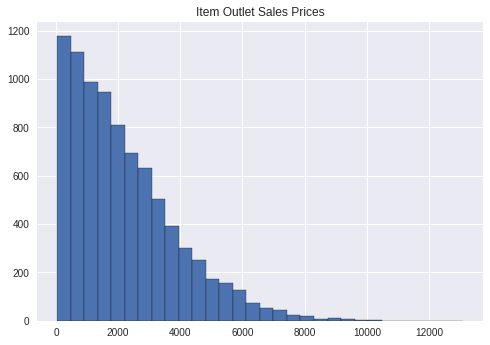

In [ ]:
plt.style.use('seaborn')
df['Item_Outlet_Sales'].hist(bins=30,edgecolor='black')
plt.ticklabel_format(useOffset=False)
plt.title('Item Outlet Sales Prices')

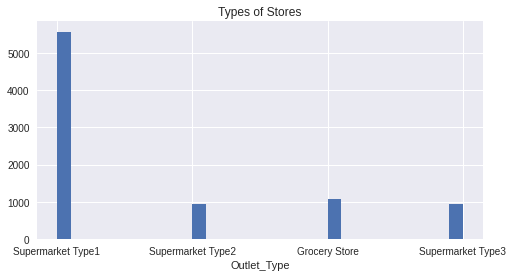

In [ ]:
#Maximum Retail Price Distribution - OOP with ax.set()
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(df['Outlet_Type'],bins=30);
ax.set(xlabel="Outlet_Type", 
       title='Types of Stores');



In [ ]:
df.dtypes

Item_Identifier               object
Item_Weight                   object
Item_Fat_Content               int64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type           int64
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
df['Item_Weight'].value_counts()

12.15    86
17.6     82
13.65    77
11.8     76
15.1     68
         ..
7.275     2
7.685     1
9.42      1
6.52      1
5.4       1
Name: Item_Weight, Length: 415, dtype: int64

In [ ]:
df['Item_Weight'].fillna(method = 'ffill', inplace = True)


## **Data Preprocessing**

In [ ]:
## Define features (X) and target (y)
X = df.drop(columns=['Item_Outlet_Sales','Item_Identifier', 'Item_Visibility','Item_Type','Outlet_Size', 'Outlet_Type', 'Item_Fat_Content', 'Outlet_Identifier','Outlet_Establishment_Year'])
y = df['Item_Outlet_Sales'].copy()

## Define features (X) and target (y)
#target = 'Item_Outlet_Sales','Item_Identifier'
#X = df.drop(columns = ['Item_Outlet_Sales','Item_Identifier'])
#y = df['Item_Outlet_Sales']


# split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           5285 non-null   object 
 1   Item_MRP              6392 non-null   float64
 2   Outlet_Location_Type  6392 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 199.8+ KB


In [ ]:
X_train.head()

,Item_MRP,Outlet_Location_Type
4776,256.4646,Tier 3
7510,179.7660,Tier 3
5828,157.2946,Tier 1
5327,82.3250,Tier 2
4810,120.9098,Tier 2


### **ColumnSelector**

In [ ]:
# Instantiate the column seelctors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')


###**Imputers**

In [ ]:
# Instantiate an imputer and scaler 
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='median')

### **Transformers**

In [ ]:
#scaler
scaler = StandardScaler()
# One hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
#create tuples
num_tuple = (scaler,num_selector)
cat_tuple = (ohe, cat_selector)

###**Column Transformer**

In [ ]:
# instantiate ColumnTransformer
preprocessor = make_column_transformer(num_tuple,cat_tuple,remainder='drop')
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63f888c70>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63f888220>)])

In [ ]:
# fit ColumnTransformer on the training data
preprocessor.fit(X_train)
# transform both the training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed
                                        

array([[ 1.82810922,  1.08494779,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60336888,  1.08494779,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24454056, -1.38477667,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.52302674, -0.14991444,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38377708, -0.14991444,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.73836105, -1.38477667,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## **Model the Data**

### **Baseline Model**

In [ ]:
# creating an instance of the model
dummy = DummyRegressor(strategy='mean')

# creating a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

# fitting the model
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63fa53f10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63f92c7c0>)])),
                ('dummyregressor', DummyRegressor())])

#### **Metrics**

In [ ]:
# Displaying model performance metrics using a function
model_metrics(dummy_pipe,x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test,
                          model_name='Dummy Model')



Dummy Model Train Scores
MAE: 1,360.2184 
MSE: 2,959,455.7045 
RMSE: 1,720.3069 
R2: 0.0000

Dummy Model Test Scores
MAE: 1,326.1210 
MSE: 2,772,144.4627 
RMSE: 1,664.9758 
R2: -0.0048



###**Linear Regression Model**


In [ ]:
# creating an instance of the model
lin_reg = LinearRegression()

# creating a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

# fitting the model
lin_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63f888c70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63f888220>)])),
                ('linearregression', LinearRegression())])

In [ ]:
# Create model pipeline
train_pred = lin_reg_pipe.predict(X_train)
test_pred = lin_reg_pipe.predict(X_test)

#### **Metrics**

In [ ]:
# Displaying model performance metrics using a function
model_metrics(lin_reg_pipe,x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test,
                          model_name='Linear Regression')

Linear Regression Train Scores
MAE: 1,018.3897 
MSE: 1,873,294.8345 
RMSE: 1,368.6836 
R2: 0.3670

Linear Regression Test Scores
MAE: 1,052.3490 
MSE: 2,014,849.0352 
RMSE: 1,419.4538 
R2: 0.2697



### **Regression Tree Model**

In [ ]:
# creates the regression tree model
dec_tree = DecisionTreeRegressor(random_state=42) 

## Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

## Fit the model
dec_tree_pipe.fit(X_train, y_train) 


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63fa53f10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff63f92c7c0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
dec_tree.get_depth()

46

In [ ]:
dec_tree.get_n_leaves()

5796

In [ ]:
# List of values to try for max_depth:
depths = list(range(2, 10)) # Will input every value between 2 and 28
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    train_score = dec_tree.score(X_train, y_train)
    test_score = dec_tree.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


Text(0, 0.5, 'R2')

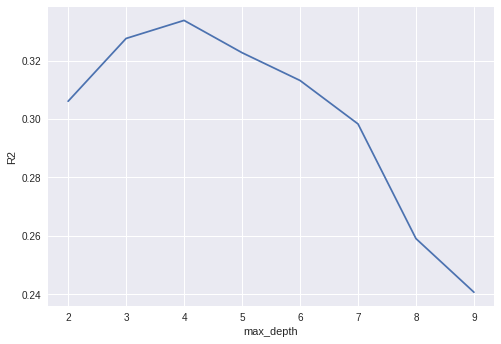

In [ ]:
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2')

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head(8)

,Test Score,Train Score
4,0.333725,0.339726
3,0.327547,0.326027
5,0.322674,0.348765
6,0.313163,0.36542
2,0.306049,0.305669
7,0.298294,0.385471
8,0.259039,0.411119
9,0.240686,0.440048


In [ ]:
# Let's run the model with our optimized value for max_depth
dec_tree_3 = DecisionTreeRegressor(max_depth = 3, random_state = 42)
dec_tree_3.fit(X_train, y_train)
train_3_score = dec_tree_3.score(X_train, y_train)
test_3_score = dec_tree_3.score(X_test, y_test)
print(train_3_score)
print(test_3_score)


0.32369197218834556
0.3171249265630133


#### **Metrics**

In [ ]:
## Display model performance metrics for decision tree
model_metrics(dec_tree_3, x_train=X_train, y_train=y_train,
              x_test=X_test, y_test=y_test,
              model_name = "Decision Tree Model")

Decision Tree Model Train Scores
MAE: 1,042.1566 
MSE: 2,001,503.6509 
RMSE: 1,414.7451 
R2: 0.3237

Decision Tree Model Test Scores
MAE: 1,007.0230 
MSE: 1,884,036.8180 
RMSE: 1,372.6022 
R2: 0.3171



In [ ]:
# Displaying model performance metrics for the linear regression model again
model_metrics(lin_reg_pipe,x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test,
                          model_name='Linear Regression')

Linear Regression Train Scores
MAE: 1,042.7767 
MSE: 2,008,939.9859 
RMSE: 1,417.3708 
R2: 0.3212

Linear Regression Test Scores
MAE: 1,002.7743 
MSE: 1,869,069.3715 
RMSE: 1,367.1391 
R2: 0.3225



## **Recommendation**

Because we need other properties of products and outlets to play crucial roles to predict sales, I will be using the Decision Tree. 
